In [1]:
import json, os, pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_rows', None)

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def set_axis_style(ax, labels, x_label, y_label):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
def flatten(nested_list):
    return [item for sublist in nested_list for item in sublist]

def unzip(zipped_data):
    return list(zip(*zipped_data))


def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [2]:
results_sop = []
results_cs = []
results_time = []
for program in os.listdir("../evaluation-data/"):
    if "max-dim" in program:
        continue
    results_for_prog_sop = []
    results_for_prog_cs = []
    results_for_prog_time = []

    for ref in os.listdir(f"../evaluation-data/{program}"):
        with open(f'../evaluation-data/{program}/{ref}/aggr.json') as f:
            data = json.load(f)
            results_for_prog_sop.append(data['sum_of_pairs'])
            results_for_prog_cs.append(data['column_score'])
            results_for_prog_time.append(data['time_ms'])
    results_sop.append((program, results_for_prog_sop))
    results_cs.append((program, results_for_prog_cs))
    results_time.append((program, results_for_prog_time))

In [3]:
column_mapping = ['RV40', 'RV11', 'RV50', 'RV12', 'RV20', 'RV30']
df_sop = pd.DataFrame.from_items(results_sop, columns=column_mapping, orient='index')
df_cs = pd.DataFrame.from_items(results_cs, columns=column_mapping, orient='index')
df_time = pd.DataFrame.from_items(results_time, columns=column_mapping, orient='index')

In [4]:
df_sop = df_sop[sorted(df_sop.columns.tolist())].sort_index()
df_cs = df_cs[sorted(df_cs.columns.tolist())].sort_index()
df_time = df_time[sorted(df_time.columns.tolist())].sort_index()

In [5]:
results_sop_detail = {}
results_cs_detail = {}
results_time_detail = {}
for program in os.listdir("../evaluation-data/"):
#     if "Mafft-Fast" not in program and "Dialign" not in program and "spam-align-w-3_d-10" not in program:
#         continue
    results_for_prog_sop = defaultdict(list)
    results_for_prog_cs = defaultdict(list)
    results_for_prog_time = defaultdict(list)

    for ref in os.listdir(f"../evaluation-data/{program}"):
        for file in os.listdir(f"../evaluation-data/{program}/{ref}"):
            if not file.endswith("json") or "aggr" in file:
                continue
            with open(f"../evaluation-data/{program}/{ref}/{file}") as f:
                data = json.load(f)
                results_for_prog_sop[ref].append(data['sum_of_pairs'])
                results_for_prog_cs[ref].append(data['column_score'])
                results_for_prog_time[ref].append(data['time_ms'])

    results_sop_detail[program] = results_for_prog_sop
    results_cs_detail[program] = results_for_prog_cs
    results_time_detail[program] = results_for_prog_time

# Comparison of SoP and CS scores between Dialign, Mafft-Fast and spam-align

Spam-align has been run with a pattern set of 5 patterns with a weight of 3 and len of 13 each. This pattern set resulted in the best results on the balibase dataset.

Mafft-Fast stands for a call of Mafft (v7.310) with the arguments `--quiet --retree 1 --maxiterate 0`  representing the strategy `FFT-NS-1 (very fast; recommended for >2000 sequences; progressive method with a rough guide tree)`.  
Mafft-Accurate in the later tables stands for a call with the arguments `--quiet --localpair --maxiterate 1000` representig the strategy `L-INS-i (probably most accurate; recommended for <200 sequences; iterative refinement method incorporating local pairwise alignment information)`

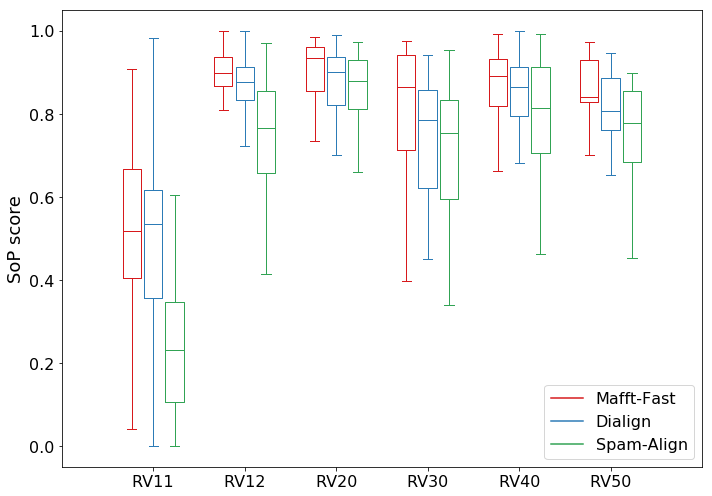

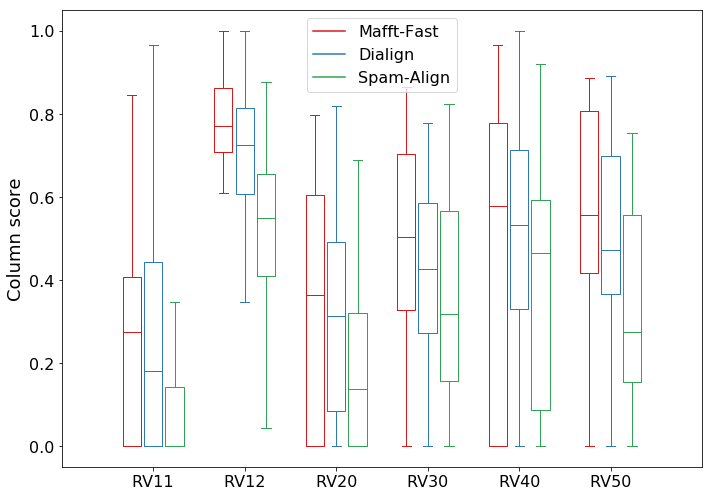

In [6]:

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def plot_detail_data(data, ylabel, filename):
    ticks, data_mafft = unzip(sorted(data['Mafft-Fast'].items()))
    data_dialign = unzip(sorted(data['Dialign'].items()))[1]
    data_spam = unzip(sorted(data['spam-align-w-2_d-11'].items()))[1]
    
    fig = plt.figure(figsize=(10,7))
    bp1 = plt.boxplot(data_mafft, positions=np.array(range(len(data_mafft)))*3.0-0.7, sym='', widths=0.6)
    bp2 = plt.boxplot(data_dialign, positions=np.array(range(len(data_dialign)))*3.0, sym='', widths=0.6)
    bp3 = plt.boxplot(data_spam, positions=np.array(range(len(data_spam)))*3.0+0.7, sym='', widths=0.6)
    
    set_box_color(bp1, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bp2, '#2C7BB6')
    set_box_color(bp3, '#31a354')

    plt.plot([], c='#D7191C', label='Mafft-Fast')
    plt.plot([], c='#2C7BB6', label='Dialign')
    plt.plot([], c='#31a354', label='Spam-Align')
    plt.legend()
    
    plt.xticks(range(0, len(ticks) * 3, 3), ticks)
    plt.xlim(-3, len(ticks)*3)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(filename)
plot_detail_data(results_sop_detail, 'SoP score', 'sop-boxplot.png')
plot_detail_data(results_cs_detail, 'Column score', 'cs-boxplot.png')

## Sum of pairs score

In [7]:
df_sop

,RV11,RV12,RV20,RV30,RV40,RV50
Dialign,0.494482,0.851870,0.868279,0.739987,0.830939,0.804629
Mafft-Accurate,0.648562,0.937168,0.927191,0.862048,0.917403,0.899301
Mafft-Fast,0.521931,0.890052,0.885096,0.812195,0.842169,0.850608
spam-align-w-2_d-10,0.225624,0.710575,0.848563,0.707815,0.767365,0.729413
spam-align-w-2_d-11,0.238148,0.718407,0.847409,0.713624,0.782116,0.726905
spam-align-w-2_d-12,0.253425,0.719423,0.837996,0.705333,0.779807,0.715988
spam-align-w-2_d-13,0.226962,0.721113,0.836024,0.722063,0.761832,0.728393
spam-align-w-2_d-14,0.247716,0.708205,0.830355,0.715264,0.756775,0.731284
spam-align-w-2_d-15,0.257446,0.717552,0.839346,0.707661,0.772384,0.707080
spam-align-w-2_d-16,0.263864,0.694868,0.833281,0.711740,0.769267,0.698232


In [8]:
df_sop.loc['spam-align-w-2_d-10':].style.apply(highlight_max)

,RV11,RV12,RV20,RV30,RV40,RV50
spam-align-w-2_d-10,0.225624,0.710575,0.848563,0.707815,0.767365,0.729413
spam-align-w-2_d-11,0.238148,0.718407,0.847409,0.713624,0.782116,0.726905
spam-align-w-2_d-12,0.253425,0.719423,0.837996,0.705333,0.779807,0.715988
spam-align-w-2_d-13,0.226962,0.721113,0.836024,0.722063,0.761832,0.728393
spam-align-w-2_d-14,0.247716,0.708205,0.830355,0.715264,0.756775,0.731284
spam-align-w-2_d-15,0.257446,0.717552,0.839346,0.707661,0.772384,0.70708
spam-align-w-2_d-16,0.263864,0.694868,0.833281,0.71174,0.769267,0.698232
spam-align-w-2_d-2,0.0622276,0.340532,0.406728,0.266578,0.298798,0.242745
spam-align-w-2_d-3,0.0901169,0.474342,0.597963,0.404273,0.442993,0.392056
spam-align-w-2_d-4,0.121769,0.54916,0.71206,0.483616,0.574064,0.523287


In [9]:
df_sop_best = df_sop.loc[['Dialign','Mafft-Accurate', 'Mafft-Fast','spam-align-w-2_d-11','spam-align-w-3_d-10'],:]
with open('df_sop_best.tex', 'w') as f:
    f.writelines(df_sop_best.to_latex())

## Column score

In [10]:
df_cs

,RV11,RV12,RV20,RV30,RV40,RV50
Dialign,0.267504,0.695353,0.320019,0.411190,0.484710,0.496890
Mafft-Accurate,0.438860,0.851518,0.486511,0.657281,0.627038,0.621163
Mafft-Fast,0.264334,0.763283,0.340603,0.467281,0.478159,0.528384
spam-align-w-2_d-10,0.069754,0.498647,0.189624,0.320461,0.384986,0.353846
spam-align-w-2_d-11,0.075156,0.499206,0.182621,0.337561,0.387202,0.336955
spam-align-w-2_d-12,0.074809,0.520504,0.192876,0.345841,0.392729,0.334753
spam-align-w-2_d-13,0.057074,0.519511,0.209395,0.355999,0.376835,0.275781
spam-align-w-2_d-14,0.063807,0.527797,0.204772,0.327716,0.376902,0.304805
spam-align-w-2_d-15,0.090372,0.500434,0.192744,0.354079,0.383638,0.317807
spam-align-w-2_d-16,0.106353,0.482960,0.192043,0.332814,0.393754,0.300216


## Execution time in ms

In [11]:
df_time

,RV11,RV12,RV20,RV30,RV40,RV50
Dialign,543,1626,40116,85923,22494,23141
Mafft-Accurate,892,1276,14676,25992,33743,26462
Mafft-Fast,275,286,469,519,691,581
spam-align-w-2_d-10,13,44,1282,2832,471,527
spam-align-w-2_d-11,12,42,1176,2400,544,539
spam-align-w-2_d-12,13,40,1141,2383,498,535
spam-align-w-2_d-13,18,57,1239,2620,468,550
spam-align-w-2_d-14,13,40,1235,2561,666,814
spam-align-w-2_d-15,18,45,1495,3220,639,736
spam-align-w-2_d-16,15,48,1196,2595,515,615


In [12]:
def aggr_data(data):
    aggr_data = defaultdict(dict)
    for key, values in data.items():
        m = re.search('spam-align-w-(?P<w>\d)_d-(?P<d>\d+)', key)
        if m is None:
            continue
        w = int(m.group('w'))
        d = int(m.group('d'))
        aggr = np.mean(flatten(values.values()))
        aggr_data[w][d] = aggr 
    return aggr_data
sop_scores = aggr_data(results_sop_detail)
cs_scores = aggr_data(results_cs_detail)
time_aggr = aggr_data(results_time_detail)

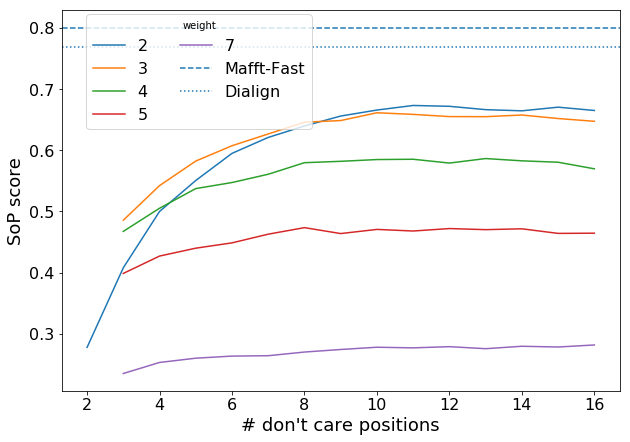

In [61]:
plt.figure(figsize=(10,7))
for weight, data in sorted(sop_scores.items()):
    x, y = unzip(sorted(data.items()))
    plt.plot(x, y,label=weight)
mafft_sop = np.mean(flatten(results_sop_detail['Mafft-Fast'].values()))
dialign_sop = np.mean(flatten(results_sop_detail['Dialign'].values()))
plt.axhline(mafft_sop, ls='--', label='Mafft-Fast')
plt.axhline(dialign_sop, ls=':', label='Dialign')
plt.xlabel('# don\'t care positions')
plt.ylabel('SoP score')
plt.legend(title='weight', ncol=2, loc='upper left', bbox_to_anchor=(0.03, 1.01))
plt.savefig('sop-by-pattern-params.png')

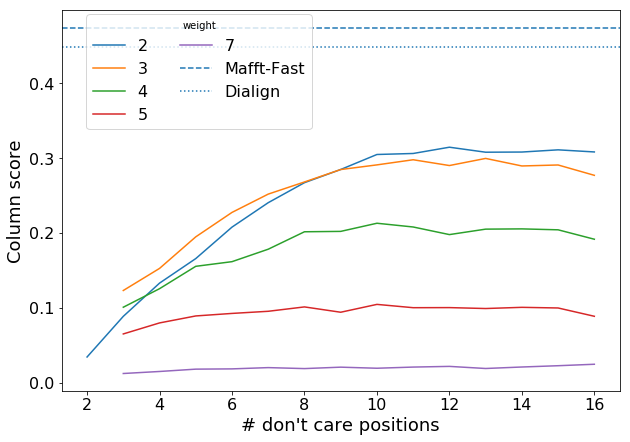

In [62]:
plt.figure(figsize=(10,7))
for weight, data in sorted(cs_scores.items()):
    x, y = unzip(sorted(data.items()))
    plt.plot(x, y,label=weight)

mafft_cs = np.mean(flatten(results_cs_detail['Mafft-Fast'].values()))
dialign_cs = np.mean(flatten(results_cs_detail['Dialign'].values()))
plt.axhline(mafft_cs, ls='--', label='Mafft-Fast')
plt.axhline(dialign_cs, ls=':', label='Dialign')
plt.xlabel('# don\'t care positions')
plt.ylabel('Column score')
plt.legend(title='weight', ncol=2, loc='upper left', bbox_to_anchor=(0.03, 1.01))
plt.savefig('cs-by-pattern-params.png')

Mean time of Dialign: 26546.72018348624
Mean time of Mafft-Fast: 463.7798165137615
Mean time of Mafft-Accurate: 16277.114678899083


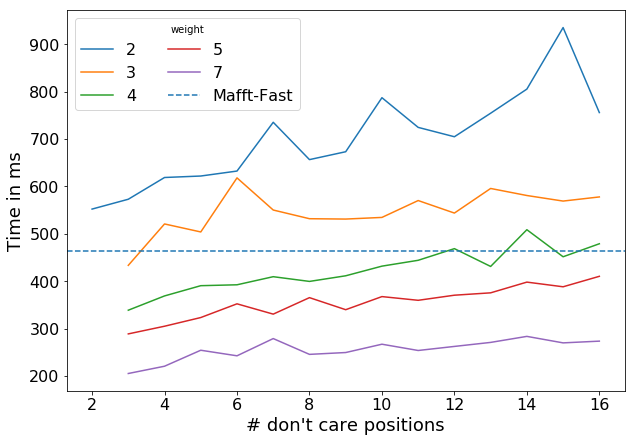

In [69]:
plt.figure(figsize=(10,7))
for weight, data in sorted(time_aggr.items()):
    x, y = unzip(sorted(data.items()))
    plt.plot(x, y,label=weight)
    
mafft_time = np.mean(flatten(results_time_detail['Mafft-Fast'].values()))
mafft_acc_time = np.mean(flatten(results_time_detail['Mafft-Accurate'].values()))
dialign_time = np.mean(flatten(results_time_detail['Dialign'].values()))
plt.axhline(mafft_time, ls='--', label='Mafft-Fast')
plt.xlabel('# don\'t care positions')
plt.ylabel('Time in ms')
plt.legend(title='weight', ncol=2, loc='upper left')
plt.savefig('time-by-pattern-params.png')
print(f'Mean time of Dialign: {dialign_time}')
print(f'Mean time of Mafft-Fast: {mafft_time}')
print(f'Mean time of Mafft-Accurate: {mafft_acc_time}')